In [35]:
# This class returns causal model objects.

class CausalModel:

    def __init__(self, name, magnitudes, derivatives, controller):
        self.name = name
        self.magnitudes = magnitudes
        self.derivatives = derivatives
        self.controller = controller
        self.influence = []
        self.proportionals = []
        self.constraints = []
        
    def __str__(self):
        return "===========\nName: %s\nMagnitudes: %s\nInfluences: %s\nProportionals: %s\nConstraints: %s\n===========\n" % (self.name, self.magnitudes, self.influence, self.proportionals, self.constraints)
        
    def getName(self):
        return self.name
    
    def getMagnitudes(self):
        return self.magnitudes
    
    def getDerivatives(self):
        return self.derivatives
    
    def getInfluences(self):
        return self.influence
    
    def getProportionals(self):
        return self.proportionals
    
    def getConstraints(self):
        return self.constraints
    
    def getController(self):
        return self.controller
    
    def setInfluence(self, other, influence):
        if influence == 'I+':
            self.influence.append((other.name, 1))
        elif influence == 'I-':
            self.influence.append((other.name,-1))
        return
        
    def setProportional(self, other, propto):
        if propto == 'P+':
            self.proportionals.append((other.name, 1))
        elif propto == 'P-':
            self.proportionals.append((other.name, -1))
        return
    
    def setConstraint(self, other, c1, c2):
        self.constraints.append((other.name, [c1, c2]))
        other.constraints.append((self.name, [c2, c1]))
        return

def initialize_pset1():
    inflow = CausalModel("Inflow", [0,1],[-1,0,1], controller=True)
    volume = CausalModel("Sink", [0,1,2],[-1,0,1], controller=False)
    outflow = CausalModel("Outflow", [0,1,2],[-1,0,1], controller=False)

    volume.setInfluence(inflow, 'I+')
    volume.setInfluence(outflow, 'I-')
    outflow.setProportional(volume, 'P+')
    outflow.setConstraint(volume, 2, 2)
    outflow.setConstraint(volume, 0, 0)
    
    return inflow, volume, outflow


In [101]:
import copy

# A class that creates states and find all new states based on a given state.
class State:
    
    # state is a dict of quantities, with given values.
    # quantities is an array of CausalModel objects that contains the 'rules' for finding new states.
    # Children will be an array of state objects, i.e. the states that were found.
    def __init__(self, quantity, state):
        self.uniqueID = 0
        self.state = state
        self.quantity = quantity
        self.children = []
        self.isInterval = True

    def __str__(self):
        return "Inflow: %s\nVolume: %s\nOutflow %s" % (self.state["Inflow"], self.state["Sink"],self.state["Outflow"])
    
    def getMagnitudes(self):
        return self.state["Inflow"][1], self.state["Sink"][1], self.state["Outflow"][1]
    
    def getDerivatives(self):
        return self.state["Inflow"][1], self.state["Sink"][1], self.state["Outflow"][1]
    
    def getChildren(self):
        return [self.children[i].state for i in range(len(self.children))]
        
    def getStateDict(self):
        return self.state
    
    def setID(self, number):
        self.number = number
        return
    
    def getID(self, number):
        return self
    
    # TODO!!!
    # Main problem: Create a method that finds all possible states given a state.
    # This function can be iterative or recursive.
    def exploreAllStates(self):
        foundItems = []
        count = 0
        
        
        while count < 1:
            
            new_item = self.exploreState(foundItems)
            
            if new_item == None:
                break
            
            foundItems.append(new_item)
            self.children.append(new_item)
            
            count += 1

        return foundItems
    
    
    # TODO!!!
    # This method should help finding all all states, by returning a single "next" state each time it's called.
    def exploreState(self, foundItems):
        
        # Fetch all derivatives and magnitudes.
        derIn, derVol, derOut = self.getDerivatives()
        magIn, magVol, magOut = self.getMagnitudes()
        new_state = None
        
        if self.isInterval == True:
            if derIn == 0:
                new_state = copy.deepcopy(self.state)
                new_state["Inflow"][1] = 1
                new_state_obj = State([self.quantity],new_state)
                if new_state_obj not in foundItems:
                    return new_state_obj

        return


IndentationError: expected an indented block (<ipython-input-101-71c7da13fffd>, line 41)

In [130]:
import networkx as nx
import matplotlib.pyplot as plt


# This should simply generate the graph for all states given an array with length N,
# where N = number of state objects. Each node will be a state. Each object will also have it's
# children stored internally, which will be the edges to the other states.
def generateStateGraph(stateList):

    # Since you cannot hash objects as keys, we need to temporarily give each object a unique value.
    # We will hash these values and give each key the corresponding child states as values. 
    # so {0 : {all children}, 1 : {all children}}
    def hashStates(stateList):
        hashed = {}
        for i in range(len(stateList)):
            stateList[i].setID(i)
            hashed[i] = stateList[i].getChildren()
        return hashed
    
    G = nx.Graph()
    
    # Give a unique number to each state and return a dict
    hashedStateList = hashStates(stateList)
    
    # Build all nodes from the dict
    G.add_nodes_from(hashedStateList)
    
    labels = {0:"A", 1:"B"}
    #for i in range(len(hashedStateList)):
    #    labels[i] = stateList[i]
    
    # Attempt to introduce the right labels... networkx not working...
    H = nx.relabel_nodes(G, labels)
    
    
    print(stateList[0].number)
    
    nx.draw(H)
    plt.show()
    
    return
    

0


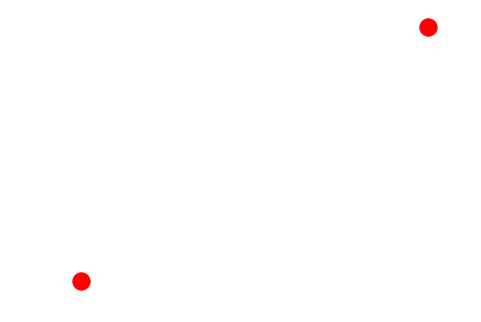

In [131]:
def main():
    # All states in the form of {"Inflow" : [0,0], "Sink" : [0,0],"Outflow" : [0,0]}
    
    state_list = []
    inf, vol, out = initialize_pset1()
    
    # Create a start state
    start_state = State([inf, vol, out],{"Inflow" : [0,0], "Sink" : [0,0],"Outflow" : [0,0]})
    
    # Find a new state based on the start_state:
    result = start_state.exploreAllStates()
    
    # Just adding the two states to the state list, which we will plot:
    state_list.append(start_state)
    state_list.append(result)
    
    graph = generateStateGraph(state_list)
    

    """
    G.add_node("a")
    G.add_nodes_from(["b","c"])

    G.add_edge(1,2)
    edge = ("d", "e")
    G.add_edge(*edge)
    edge = ("a", "b")
    G.add_edge(*edge)
    """
    
    
    #print(result)
    #print(start_state)
    #print(result.getChildren())
    #print(start_state.getChildren())
    #print(graph_list)
    
    
main()